In [0]:
# all plots will be set directly below the code cell that produced it
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import clear_output
# set inline plots size
plt.rcParams["figure.figsize"] = (16, 10) # (w, h)
import numpy as np
import time
import os
import cv2
import zipfile
import tarfile
from collections import namedtuple
from google.colab.patches import cv2_imshow
from xml.dom import minidom
import pandas as pd
from google.colab import files

In [0]:
!wget "https://drive.google.com/open?id=1Dbr2NMBlJLrpqvcMG_7Ae3gC4XOcqt3p" -O dictionary.txt
clear_output()

In [0]:
#load images from local disc because IDK how to load from noraml drive!!!! FUCK!!
uploaded = files.upload()
clear_output()

In [4]:
import nltk
nltk.download('punkt')
from nltk import tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
text = "Mike is sad. Jenny plays ball. sun shines"
# sentance = ["a", "b" , "c"]
sentances = tokenize.sent_tokenize(text)
print (sentances)

['Mike is sad.', 'Jenny plays ball.', 'sun shines']


In [0]:
def capital_to_norm(words):
  word = ["a", "b" , "c"]
  for word in words:
    word = word.lower()
  return(word)

In [7]:
i = 0
BoW = []
all_BoW = []
for sentance in sentances:
  words = sentance.split()
  BoW = []
  for word in words:
    word = word.lower()
    word = word.replace('.', '')
    BoW.append(word)
  all_BoW.append(BoW)
print(all_BoW)

[['mike', 'is', 'sad'], ['jenny', 'plays', 'ball'], ['sun', 'shines']]


In [0]:
# import math
# df1 = pd.read_csv('book.csv', na_values='-', sep = ';') 
# df1 = df1.fillna(0)
# obj = df1.obj
# code = df1.code
# ID = []
# all_ID = []
# true_ID = []
# for BoW in all_BoW:
#   num = 0
#   ID = []
#   for word in BoW:
#     for index, row in enumerate(obj):
#       if word == row:
#           ID.append(code[index])
#       if isinstance(code[index], int):
#           num = num+code[index]
#   all_ID.append(ID)
# print(all_ID)

In [11]:
import math
df1 = pd.read_csv('book.csv', na_values='-', sep = ';') 
df1 = df1.fillna(0)
obj = df1.obj
code = df1.code
ID = []
all_ID = []
true_ID = []
for BoW in all_BoW:
  num = 0
  ID = []
  for word in BoW:
    for index, row in enumerate(obj):
      if word == row:
        try:
          val = int(code[index])
          num = num+val
          # print(code[index], 'is num')
        except:
          ID.append(code[index])
  ID.append(num)
  all_ID.append(ID)
print(all_ID)

[['hb0', 3], ['hb1', 't_2s', 0], ['a_3s', 0]]


In [0]:
# trueID = []
# ident = []
# for IDs in all_ID:
#   for id in IDs:
#     if (id == 'hb0') or (id == 'hb1'):
#       true_id = str(id) + '_' + str(IDs[len(IDs)-1])
#       trueID.append(true_id)
#     elif not isinstance(id, int):
#       true_id = id
#       trueID.append(true_id)
# print(trueID)

In [12]:
trueID = []
for IDs in all_ID:
  ident = []
  for id in IDs:
    if (id == 'hb0') or (id == 'hb1'):
      true_id = str(id) + '_' + str(IDs[len(IDs)-1]) + 's'
      ident.append(true_id)
    elif not isinstance(id, int):
      true_id = id
      ident.append(true_id)
  trueID.append(ident)
print(trueID)

[['hb0_3s'], ['hb1_0s', 't_2s'], ['a_3s']]


hb0_3s.png


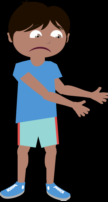

hb1_0s.png


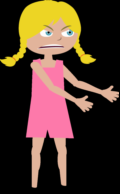

t_2s.png


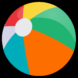

a_3s.png


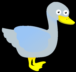

In [14]:
from google.colab.patches import cv2_imshow
for IDs in trueID:
  for id in IDs:
    img = id + '.png'
    print(img)
    image = cv2.imread(img, cv2.COLOR_BGR2RGB)
    cv2_imshow(image)

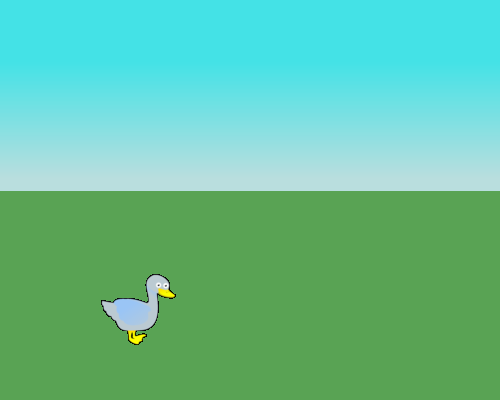

In [53]:
background =  cv2.imread('background.png', cv2.COLOR_BGR2RGB)
height, width, channels = image.shape
for h in range(0, width):
  for w in range (0, height):
    if not (image[w][h][2] == 0):
      background[273+w, 100+h] = image[w][h]
cv2_imshow(background)